# Leitura e Formatação dos Dados de Desmatamento

In [ ]:
import geopandas as gpd
import ast
import requests
import os
import rasterio
import pandas as pd


# Carregar o arquivo GeoPackage
gdf = gpd.read_file(r"C:\Users\alanb\Documents\Desmatamento - Alertas [2024-11]\deforestation_alerts_awa.gpkg")
gdf.columns

Index(['is_valid', 'analysis_date', 'area', 'location', 'source_images_date',
       'source_images', 'internal_storage_path', 'geometry'],
      dtype='object')

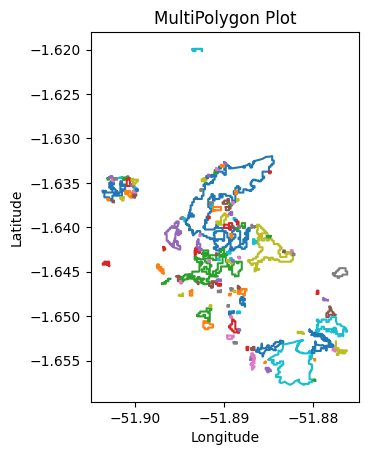

In [12]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

# Supondo que row['geometry'] seja um objeto MultiPolygon
multipolygon = gdf_awa['geometry'][1]

# Criar uma figura e um eixo
fig, ax = plt.subplots()

# Plotar cada polígono no MultiPolygon
for polygon in multipolygon.geoms:
    x, y = polygon.exterior.xy
    ax.plot(x, y)

# Configurar os eixos
ax.set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MultiPolygon Plot')

# Mostrar o gráfico
plt.show()

In [40]:
sorted(gdf['analysis_date'].unique())

[Timestamp('2023-08-26 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-09-10 00:00:00'),
 Timestamp('2023-09-15 00:00:00'),
 Timestamp('2023-09-20 00:00:00'),
 Timestamp('2023-09-25 00:00:00'),
 Timestamp('2023-09-30 00:00:00'),
 Timestamp('2023-10-05 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-15 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-10-25 00:00:00'),
 Timestamp('2023-10-30 00:00:00'),
 Timestamp('2023-11-04 00:00:00'),
 Timestamp('2023-11-09 00:00:00'),
 Timestamp('2023-11-14 00:00:00'),
 Timestamp('2023-11-19 00:00:00'),
 Timestamp('2023-11-24 00:00:00'),
 Timestamp('2023-11-29 00:00:00'),
 Timestamp('2023-12-09 00:00:00'),
 Timestamp('2023-12-14 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-24 00:00:00'),
 Timestamp('2023-12-29 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-01-13 00:00:00'),
 Timestamp('2024-01-18 00:00:00'),
 Timestamp('2024-01-

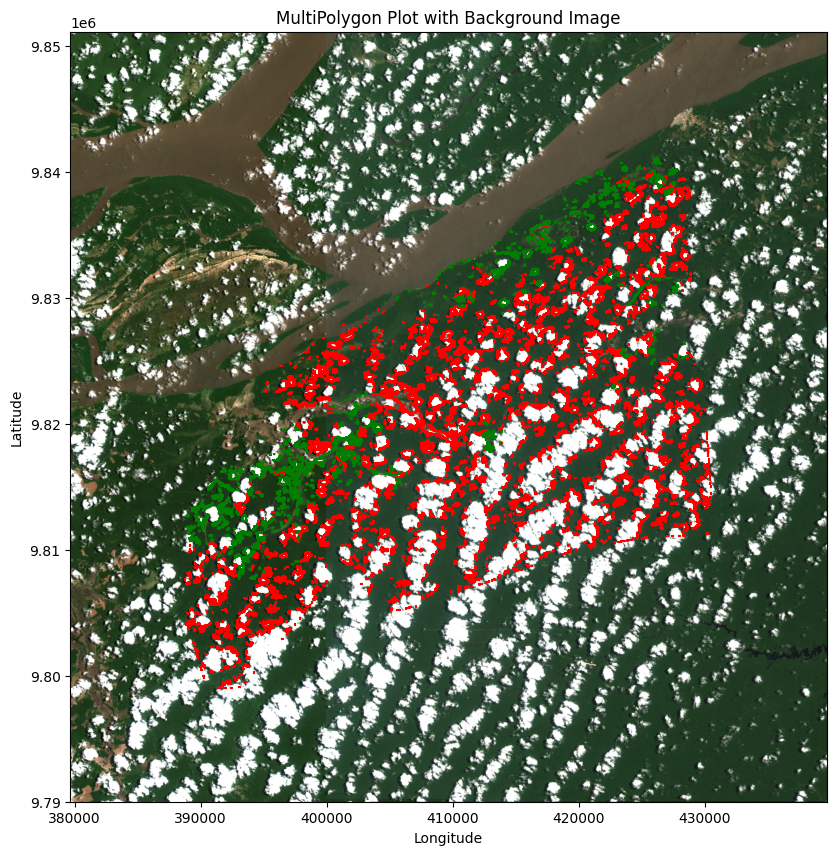

In [49]:
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import MultiPolygon
from shapely.ops import transform
from pyproj import Proj, Transformer
import numpy as np

gdf_local = gdf[(gdf['analysis_date'] == '2023-09-20')].reset_index(drop=True)

# Caminho para a imagem
image_path = f"G:/Meu Drive/Desmatamento_Arquivos/awa/{gdf_local['internal_storage_path'][0]}/TCI_merged.tiff"

# Ler a imagem usando rasterio
with rasterio.open(image_path) as src:
    image = src.read([1, 2, 3]).transpose(1,2,0)  # Ler as três primeiras bandas (RGB)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    image_crs = src.crs  # Sistema de coordenadas da imagem

# Sistema de coordenadas dos polígonos (supondo que seja WGS84)
polygons_crs = 'EPSG:4326'

# Criar um transformador para converter as coordenadas
transformer = Transformer.from_crs(polygons_crs, image_crs, always_xy=True)

# Função para transformar as coordenadas dos polígonos
def transform_polygon(polygon):
    return transform(transformer.transform, polygon)

# Supondo que row['geometry'] seja um objeto MultiPolygon
#multipolygon = gdf_awa['geometry'][0]

# Criar uma figura e um eixo
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar a imagem de fundo
ax.imshow(np.squeeze(image), extent=extent)

for i in range(len(gdf_local)):
    multipolygon = gdf_local['geometry'][i] 

    # Transformar os polígonos para o sistema de coordenadas da imagem
    transformed_multipolygon = MultiPolygon([transform_polygon(polygon) for polygon in multipolygon.geoms])

    color = 'red'
    
    if gdf_local['is_valid'][i] == True:
        color = 'green'
    # Plotar cada polígono no MultiPolygon transformado
    for polygon in transformed_multipolygon.geoms:
        x, y = polygon.exterior.xy
        ax.plot(x, y, color=color)
        #print(x, y)

# Configurar os eixos
ax.set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MultiPolygon Plot with Background Image')

# Mostrar o gráfico
plt.show()